In [1]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 709 kB 538 kB/s eta 0:00:01


In [2]:
#This is so that the plots are there along with the code in the notebook rather than a popup
%matplotlib inline

import os
from os.path import isfile,join
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import torchvision.transforms as T
from torch.nn.modules import padding
from scipy.ndimage import distance_transform_edt
from monai.metrics import HausdorffDistanceMetric,SurfaceDistanceMetric
import math
import sys

In [4]:
# For reproducing results
seed = 42
#random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Getting Data

In [5]:
# GPU | CPU
def get_default_device():
    
    if torch.cuda.is_available():
        return torch.device('cuda:0')
    else:
        return torch.device('cpu')

def to_device(data,device):
    
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    
    return data.to(device,non_blocking = True)

In [6]:
''' ----------------------------------------------------------
    All the content here is intermediate data used to obtain df
    None of these will be referenced later in the notebook 
    ---------------------------------------------------------- '''

base_path = "../processed/"

file_names = {"image": "img_crp_v2.npy", 
              "esophagus": "/structure/Esophagus_crp_v2.npy",
              "heart": "/structure/Heart_crp_v2.npy",
              "lung_L": "/structure/Lung_L_crp_v2.npy",
              "lung_R": "/structure/Lung_R_crp_v2.npy",
              "spinal_cord": "/structure/SpinalCord_crp_v2.npy"} 

dirs = [(base_path + f + "/") for f in os.listdir(base_path) if not isfile(join(base_path,f))]

data = [[f + file_names["image"],
         f + file_names["esophagus"],
         f + file_names["heart"],
         f + file_names["lung_L"],
         f + file_names["lung_R"],
         f + file_names["spinal_cord"]] for f in dirs]


In [7]:
#df contains all data regarding input data
df = pd.DataFrame(data, columns = ['Image','Esophagus','Heart','Lung_L','Lung_R','SpinalCord'])
df.head()

,Image,Esophagus,Heart,Lung_L,Lung_R,SpinalCord
0,../processed/LCTSC-Train-S3-005/img_crp_v2.npy,../processed/LCTSC-Train-S3-005//structure/Eso...,../processed/LCTSC-Train-S3-005//structure/Hea...,../processed/LCTSC-Train-S3-005//structure/Lun...,../processed/LCTSC-Train-S3-005//structure/Lun...,../processed/LCTSC-Train-S3-005//structure/Spi...
1,../processed/LCTSC-Train-S1-004/img_crp_v2.npy,../processed/LCTSC-Train-S1-004//structure/Eso...,../processed/LCTSC-Train-S1-004//structure/Hea...,../processed/LCTSC-Train-S1-004//structure/Lun...,../processed/LCTSC-Train-S1-004//structure/Lun...,../processed/LCTSC-Train-S1-004//structure/Spi...
2,../processed/LCTSC-Train-S2-004/img_crp_v2.npy,../processed/LCTSC-Train-S2-004//structure/Eso...,../processed/LCTSC-Train-S2-004//structure/Hea...,../processed/LCTSC-Train-S2-004//structure/Lun...,../processed/LCTSC-Train-S2-004//structure/Lun...,../processed/LCTSC-Train-S2-004//structure/Spi...
3,../processed/LCTSC-Train-S3-008/img_crp_v2.npy,../processed/LCTSC-Train-S3-008//structure/Eso...,../processed/LCTSC-Train-S3-008//structure/Hea...,../processed/LCTSC-Train-S3-008//structure/Lun...,../processed/LCTSC-Train-S3-008//structure/Lun...,../processed/LCTSC-Train-S3-008//structure/Spi...
4,../processed/LCTSC-Train-S3-012/img_crp_v2.npy,../processed/LCTSC-Train-S3-012//structure/Eso...,../processed/LCTSC-Train-S3-012//structure/Hea...,../processed/LCTSC-Train-S3-012//structure/Lun...,../processed/LCTSC-Train-S3-012//structure/Lun...,../processed/LCTSC-Train-S3-012//structure/Spi...


## Datagen

In [8]:
def Datagen_CT(df,img_size,seg_organ,window_size):

    for _, row in df.iterrows():

        image = np.load(row["Image"])
        image = np.moveaxis(image,0,-1)
        image = cv2.resize(image, (img_size,img_size))
        image = np.swapaxes(image,0,-1)

        mask = np.load(row[seg_organ])
        mask = np.moveaxis(mask,0,-1)
        mask = cv2.resize(mask , (img_size,img_size))
        mask = np.swapaxes(mask,0,-1)

        #Padding to fit window_size
        image = np.concatenate((np.zeros((int(window_size/2),img_size,img_size)),image))
        image = np.concatenate((image,np.zeros((int(window_size),img_size,img_size)))) #This is to ensure that the last valid slice can be reached
        mask = np.concatenate((np.zeros((int(window_size/2),img_size,img_size)),mask))
        mask = np.concatenate((mask,np.zeros((int(window_size/2),img_size,img_size))))

        half_window = window_size//2
        slice_index = half_window + 1 #the index of the next slice to be examined

        while slice_index + window_size + half_window - 1 <= mask.shape[0]:#we put mask here because image has a longer size to adjust for the last slice
            images = image[slice_index - half_window : slice_index + window_size + half_window,:,:]
            masks = mask[slice_index: slice_index + window_size,:,:]

            slice_index = slice_index + window_size
            images = np.expand_dims(images,axis=1).astype('float32')
            masks = np.expand_dims(masks,axis=1).astype('float32')

            yield images, masks


## Model

In [9]:
class AttentionHead(nn.Module):
    def __init__(self,dim_in,dim_q,dim_k,linear_layer_needed,dim_o=0):
        super(AttentionHead,self).__init__()
        self.q = nn.Linear(dim_in,dim_q)
        self.k = nn.Linear(dim_in,dim_k)
        self.v = nn.Linear(dim_in,dim_k)
        self.linear_layer_needed = linear_layer_needed
        if linear_layer_needed:
            self.linear = nn.Linear(dim_k,dim_o)

    def forward(self,query,key,value):
        query = self.q(query)
        key = self.k(key)
        value = self.v(value)

        temp = query.matmul(key.transpose(0,1))
        scale = query.size(-1) ** 0.5 #feature dimension
        softmax = F.softmax(temp/scale, dim=-1)
        attn_mat = softmax.matmul(value)
        if self.linear_layer_needed:
            return self.linear(attn_mat)
        else:
            return attn_mat

In [10]:
class AttentionGate(nn.Module):
    
    def __init__(self,F_g,F_x,F_int,pool_size):
        super(AttentionGate,self).__init__()
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True)
        self.W_x = nn.Conv2d(F_x,F_int,kernel_size=1,stride=1,padding=0,bias=True)
        self.psi = nn.Conv2d(F_int,1,kernel_size=1,stride=1,padding=0,bias=True)
        self.pool_size = pool_size
        self.maxpool = nn.MaxPool2d((self.pool_size,self.pool_size))
        
        self.batchnorm_g = nn.BatchNorm2d(F_int)
        self.batchnorm_x = nn.BatchNorm2d(F_int)
    
    def forward(self,g,x): #g : lower layer and x : corresponding encoder img 
        g1 = self.W_g(g)
        g1 = self.batchnorm_g(g1)
        
        x1 = self.W_x(x)
        x1 = self.batchnorm_x(x1)
        x1 = self.maxpool(x1)
        
        interim = F.relu(g1+x1)
        psi = self.psi(interim)
        psi = torch.sigmoid(psi)
        
        psi = F.interpolate(psi,scale_factor=(self.pool_size,self.pool_size),mode='bilinear',align_corners=True)
        return x * psi

In [11]:
class EncoderBlock(nn.Module):
    
    def __init__(self,dim_i,dim_o):
        super(EncoderBlock,self).__init__()
        
        self.conv1 = nn.Conv2d(dim_i,dim_o,3,padding="same")
        self.batchnorm1 = nn.BatchNorm2d(dim_o)
        self.conv2 = nn.Conv2d(dim_o,dim_o,3,padding="same")
        self.batchnorm2 = nn.BatchNorm2d(dim_o)
        
    def forward(self,x):
        
        x1 = self.conv1(x)
        x1 = F.leaky_relu(x1)
        x1 = self.batchnorm1(x1)
        x1 = self.conv2(x1)
        x1 = F.leaky_relu(x1)
        x1 = self.batchnorm2(x1)
        return x1

class UNet_Encoder(nn.Module):
    
    def __init__(self):
        super(UNet_Encoder,self).__init__()

        self.enc1 = EncoderBlock(1,32)
        self.enc2 = EncoderBlock(32,64)
        self.enc3 = EncoderBlock(64,128)
        self.enc4 = EncoderBlock(128,256)
        self.enc5 = EncoderBlock(256,512)
        self.enc6 = EncoderBlock(512,1024)
        
        self.maxpool_x2 = nn.MaxPool2d((2,2))
        self.maxpool_x4 = nn.MaxPool2d((4,4))
    
    def forward(self,x):

        x1 = self.enc1(x)

        x2 = self.maxpool_x4(x1)
        x2 = self.enc2(x2)
        
        x3 = self.maxpool_x4(x2)
        x3 = self.enc3(x3)

        x4 = self.maxpool_x4(x3)
        x4 = self.enc4(x4)

        x5 = self.maxpool_x2(x4)
        x5 = self.enc5(x5)

        x6 = self.maxpool_x2(x5)
        x6 = self.enc6(x6)
        
        return (x1,x2,x3,x4,x5,x6)

In [12]:
class DecoderBlock(nn.Module):
    
    def __init__(self,dim_i,dim_o,up_size):
        super(DecoderBlock,self).__init__()
        
        self.trans_conv = nn.ConvTranspose2d(dim_i,dim_o,kernel_size=up_size,stride=up_size)
        self.attn_gate = AttentionGate(F_g=dim_i,F_x=dim_o,F_int=dim_o,pool_size=up_size)
        
        self.conv_r1 = nn.Conv2d(dim_i,dim_o,kernel_size=3,padding="same")
        self.conv_r2 = nn.Conv2d(dim_o,dim_o,kernel_size=3,padding="same")
        
        self.batchnorm_r1 = nn.BatchNorm2d(dim_o)
        self.batchnorm_r2 = nn.BatchNorm2d(dim_o)
        
    def forward(self,x,x_enc):
        xi = self.trans_conv(x)
        xa = self.attn_gate(x,x_enc)
        xi = torch.cat((xi,xa),dim=1) #concatenating to the channel dimension
        
        xi = self.conv_r1(xi)
        xi = F.leaky_relu(xi)
        xi = self.batchnorm_r1(xi)
        
        xi = self.conv_r2(xi)
        xi = F.leaky_relu(xi)
        xi = self.batchnorm_r2(xi)
        
        return xi
        


class UNet_Decoder(nn.Module):
    
    def __init__(self):
        super(UNet_Decoder,self).__init__()
        
        #since last two maxpools are x4, the filter and strides of first two transpose convs are 4 each
        self.dec1 = DecoderBlock(1024,512,2)
        self.dec2 = DecoderBlock(512,256,2)
        self.dec3 = DecoderBlock(256,128,4)
        self.dec4 = DecoderBlock(128,64,4)
        self.dec5 = DecoderBlock(64,32,4)

    
    def forward(self,x1,x2,x3,x4,x5,x_attn,window_size): 
        

        xi = self.dec1(x_attn,x5[(window_size//2):-(window_size//2)])
        xi = self.dec2(xi,x4[(window_size//2):-(window_size//2)])
        xi = self.dec3(xi,x3[(window_size//2):-(window_size//2)])
        xi = self.dec4(xi,x2[(window_size//2):-(window_size//2)])
        xi = self.dec5(xi,x1[(window_size//2):-(window_size//2)])
        
        return xi

In [13]:
#Input size is (window_size, 1, 512, 512)
class UNet(nn.Module):

    def __init__(self,encoder,decoder,attention):
        super(UNet,self).__init__()
        
        self.encoder = encoder
        self.attn_head1 = attention[0]
        self.attn_head2 = attention[1]
        self.decoder = decoder
        self.conv_f = nn.Conv2d(32,1,kernel_size=1)

    def attention_layer_calc(self,x_flatten,window_size):

        i = 0
        x_attn = None

        while i + window_size <= x_flatten.shape[0]:
            img_enc = x_flatten[i:i+window_size]
            
            #simple positional encoding
            img_pos_enc = None
            for ind1 in range(img_enc.shape[0]):
                pos_temp = (img_enc[ind1] + ind1/img_enc.shape[0])[None,:]
                if img_pos_enc is None:
                    img_pos_enc = pos_temp
                else:
                    img_pos_enc = torch.cat((img_pos_enc,pos_temp))

            temp1 = self.attn_head1(img_pos_enc,img_pos_enc,img_pos_enc)
            temp2 = self.attn_head2(temp1,temp1,temp1)[window_size//2][None,:]

            i = i + 1
            if x_attn is None:
                x_attn = temp2
            else:
                x_attn = torch.cat((x_attn,temp2))

        x_attn = x_attn.reshape([x_attn.shape[0],1024,2,2])
        return x_attn


    def forward(self,x,window_size): #note: the entire batch is passed in 

        #Encoder
        x1,x2,x3,x4,x5,x6 = self.encoder(x)

        #Attention
        x_flatten = torch.flatten(x6,start_dim=1)
        
        x_attn = self.attention_layer_calc(x_flatten,window_size)
        x_attn = F.leaky_relu(x_attn)

        #Decoder
        xi_1 = self.decoder(x1,x2,x3,x4,x5,x_attn,window_size)

        #Final
        xf = self.conv_f(xi_1)
        xf = torch.sigmoid(xf)
        return xf

## Loss Function

In [14]:
def log_dice_loss(y_pred,y_true,smooth=1):
    y_true_f = torch.flatten(y_true,start_dim=1)
    y_pred_f = torch.flatten(y_pred,start_dim=1)
    
    intersection = torch.sum(y_true_f * y_pred_f,1)
    result = torch.log((2. * intersection + smooth) / (torch.sum(y_true_f,1) + torch.sum(y_pred_f,1) + smooth))
    dice_loss = -1 * torch.sum(result)/y_pred.shape[0]
    return  dice_loss

def dice_loss(y_pred,y_true,smooth=1):
    y_true_f = torch.flatten(y_true,start_dim=1)
    y_pred_f = torch.flatten(y_pred,start_dim=1)
    
    intersection = torch.sum(y_true_f * y_pred_f,1)
    result = (2. * intersection + smooth) / (torch.sum(y_true_f,1) + torch.sum(y_pred_f,1) + smooth)
    dice_loss = torch.sum(1-result)/y_pred.shape[0]
    return  dice_loss

def focal_loss(y_pred,y_true,smooth=1):
    y_true_f = torch.flatten(y_true,start_dim=1)
    y_pred_f = torch.flatten(y_pred,start_dim=1)

#     #dice metric
#     intersection = torch.sum(y_true_f * y_pred_f,1)
#     result = (2. * intersection + smooth) / (torch.sum(y_true_f,1) + torch.sum(y_pred_f,1) + smooth)
#     dice_loss = -1 * torch.sum(torch.log(result))

    #focal loss
    gamma = 2
    alpha = 0.25

    bce_loss = F.binary_cross_entropy_with_logits(y_pred_f,y_true_f,reduction='none')
    pt = torch.exp(-1 * bce_loss)

    temp_at = to_device(torch.tensor([alpha,1-alpha]),get_default_device())
    y_true_f = y_true_f.type(torch.long)
    at = ((1-alpha) * (1 - y_true_f)) + (alpha * y_true_f)

    F_loss = torch.sum(at * ((1-pt) ** gamma) * bce_loss)

    return  (F_loss) / y_pred.shape[0]

## Eval Metrics

In [15]:
#IOU [Between 0-1: Higher value => Better results]
def iou_metric(y_pred,y_true,smooth=1):
    y_true_f = torch.flatten(y_true,start_dim=1)
    y_pred_f = torch.flatten(y_pred,start_dim=1)
    
    y_pred_f[y_pred_f >= 0.5] = 1
    y_pred_f[y_pred_f < 0.5] = 0

    intersection = torch.sum(y_true_f * y_pred_f,1)
    union = torch.sum(y_true_f,1) + torch.sum(y_pred_f,1) - torch.sum(y_true_f * y_pred_f,1)
    iou_score = torch.sum((intersection + smooth)/(union + smooth)) / y_pred.shape[0]
    return  iou_score

#Dice [Between 0-1: Higher value => Better results]
def dice_metric(y_pred,y_true,smooth=1):
    y_true_f = torch.flatten(y_true,start_dim=1)
    y_pred_f = torch.flatten(y_pred,start_dim=1)
    
    y_pred_f[y_pred_f >= 0.5] = 1
    y_pred_f[y_pred_f < 0.5] = 0

    intersection = torch.sum(y_true_f * y_pred_f,1)
    result = torch.sum((2. * intersection + smooth) / (torch.sum(y_true_f,1) + torch.sum(y_pred_f,1) + smooth))
    dice_score = result/y_pred.shape[0]
    return  dice_score

#MSD [Between 0-infinity: Smaller value => Better results]
def msd_metric(y_pred,y_true):
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0

    msd = SurfaceDistanceMetric(include_background=True)
    val = torch.sum(msd(y_pred,y_true))

    if val.isnan():
        return to_device(torch.tensor(0),get_default_device())

    return val

#HD95 [Between 0-infinity: Smaller value => Better results]
def hd95_metric(y_pred,y_true):
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0

    hd = HausdorffDistanceMetric(percentile=95,reduction="none",include_background=False)
    val = torch.sum(hd(y_pred,y_true))

    if val.isnan():
        return to_device(torch.tensor(0),get_default_device())

    return val

#Precision [Between 0-1: Larger value => Better results]
def precision_metric(y_pred,y_true):
    y_true = torch.flatten(y_true,start_dim=1)
    y_pred = torch.flatten(y_pred,start_dim=1)

    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0

    tp = torch.sum(y_pred * y_true,1)
    fp = torch.sum(y_pred * (1 - y_true),1)

    if 0 in tp+fp:
        return to_device(torch.tensor(0),get_default_device())

    precision = torch.sum(tp/(tp+fp))/y_pred.shape[0]
    return precision

#Recall [Between 0-1: Larger value => Better results]
def recall_metric(y_pred,y_true):
    y_true = torch.flatten(y_true,start_dim=1)
    y_pred = torch.flatten(y_pred,start_dim=1)

    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0

    tp = torch.sum(y_pred * y_true,1)
    fn = torch.sum((1-y_pred) * y_true,1)

    if 0 in tp+fn:
        return to_device(torch.tensor(0),get_default_device())

    recall = torch.sum(tp/(tp+fn))/y_pred.shape[0]
    return recall

## Eval Function

In [16]:
def eval(model,test_df,img_size,seg_organ,window_size,epoch=0,epochs=0):
    #epoch and epoch size is passed if this function is called during training in between epochs
    model.eval()
    test_dataloader = Datagen_CT(df=test_df,img_size=img_size,seg_organ=seg_organ,window_size=window_size)

    iou_val = 0
    dice_val = 0
    msd_val = 0
    hd95_val = 0
    pre_val = 0
    re_val = 0

    count = 0
    for batch_idx, (X,y) in enumerate(test_dataloader):
        X = to_device(torch.tensor(X, requires_grad=True),get_default_device())
        y = to_device(torch.tensor(y, requires_grad=True),get_default_device())

        output = model(X,window_size)
        iou_val += iou_metric(output,y).item()
        dice_val += dice_metric(output,y).item()
        # msd_val += msd_metric(output,y).item()
        # hd95_val += hd95_metric(output,y).item()
        pre_val += precision_metric(output,y).item()
        re_val += recall_metric(output,y).item()

        count = count + 1
    
    print('-------------------------')
    print('End of Epoch [{}/{}]   Dice Metric: {:.4f}  IoU Metric: {:.4f}  \n  Precision Metric: {:.4f}  Recall Metric: {:.4f}'.format(epoch+1,epochs,dice_val/count,iou_val/count,pre_val/count,re_val/count))
    print('\n')
    sys.stdout.flush()
    
    dice_val = dice_val/count
    iou_val = iou_val/count
    return dice_val, iou_val
    

## Fit Function

In [17]:
def fit(model,img_size,seg_organ,window_size,loss_fn,optimizer,scheduler,epochs,train_df,test_df,validate=False,print_every=1):


    for epoch in range(epochs):

        model.train()
        train_dataloader = Datagen_CT(df=train_df,img_size=img_size,seg_organ=seg_organ,window_size=window_size)
    
        for batch_idx, (X,y) in enumerate(train_dataloader):
            X = to_device(torch.tensor(X, requires_grad=True),get_default_device())
            y = to_device(torch.tensor(y, requires_grad=True),get_default_device())

            optimizer.zero_grad()
            output = model(X,window_size)
            loss = loss_fn(output,y)
            loss.backward()
            optimizer.step()

            if batch_idx % print_every == 0:
                print('Epoch [{}/{}]   Batch {}   Loss: {:.4f}    Max: {:.4f}'.format(epoch+1,epochs,batch_idx,loss.item(),torch.max(output)))
                sys.stdout.flush()
        

                plt.subplot(1,3,1)
                plt.imshow(X.cpu().detach().numpy()[window_size//2][0])

                plt.subplot(1,3,2)
                plt.imshow(y.cpu().detach().numpy()[0][0])

                plt.subplot(1,3,3)
                plt.imshow(output.cpu().detach().numpy()[0][0])

                plt.show()


        print('Epoch [{}/{}]   Batch {}   Loss: {:.4f}    lr: {:.10f}'.format(epoch+1,epochs,batch_idx,loss.item(),optimizer.param_groups[0]['lr']))
        sys.stdout.flush()
        
        scheduler.step()

        if validate:
            dsc,iou = eval(model=model,test_df=test_df,img_size=img_size,seg_organ=seg_organ,window_size=window_size,epoch=epoch,epochs=epochs)
            print('End of Epoch [{}/{}]   Dice Metric: {:.4f}  IoU Metric: {:.4f}'.format(epoch+1,epochs,dsc,iou))


## Training

In [18]:
#Parameters
img_size = 512
epochs = 100
seg_organ = 'Lung_L'
train_test_split = 0.8
window_size = 5

#Dataset Specific
train_df = df[:int(train_test_split*df.shape[0])].reset_index(drop=True)
test_df = df[int(train_test_split*df.shape[0]):].reset_index(drop=True)

In [43]:
#Model Specific
enc = UNet_Encoder()
dec = UNet_Decoder()
attn = [AttentionHead(dim_in=4096,dim_q=1024,dim_k=1024,linear_layer_needed=False),
        AttentionHead(dim_in=1024,dim_q=1024,dim_k=1024,linear_layer_needed=True,dim_o=4096)]
model = UNet(enc,dec,attn)
model = to_device(model,get_default_device())

In [44]:
# model.load_state_dict(torch.load('sma_lung_l_30epochs'))

In [49]:
#Training Specific
loss_fn = dice_loss

# optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=0.1) #2,4

Epoch [1/100]   Batch 0   Loss: 0.4582    Max: 1.0000


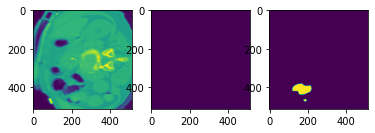

Epoch [1/100]   Batch 1000   Loss: 0.0262    Max: 1.0000


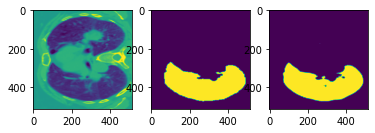

Epoch [1/100]   Batch 1208   Loss: 0.9999    lr: 0.0100000000
-------------------------
End of Epoch [1/100]   Dice Metric: 0.4271  IoU Metric: 0.3606  
  Precision Metric: 0.6052  Recall Metric: 0.1069


End of Epoch [1/100]   Dice Metric: 0.4271  IoU Metric: 0.3606
Epoch [2/100]   Batch 0   Loss: 0.9999    Max: 1.0000


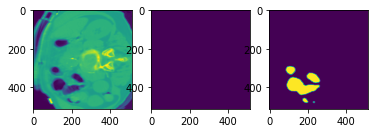

Epoch [2/100]   Batch 1000   Loss: 0.0218    Max: 1.0000


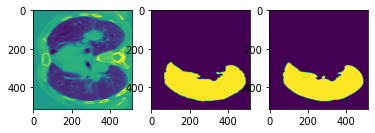

Epoch [2/100]   Batch 1208   Loss: 0.9999    lr: 0.0100000000
-------------------------
End of Epoch [2/100]   Dice Metric: 0.6385  IoU Metric: 0.5927  
  Precision Metric: 0.5555  Recall Metric: 0.5308


End of Epoch [2/100]   Dice Metric: 0.6385  IoU Metric: 0.5927
Epoch [3/100]   Batch 0   Loss: 0.9999    Max: 1.0000


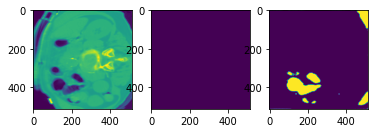

Epoch [3/100]   Batch 1000   Loss: 0.0645    Max: 1.0000


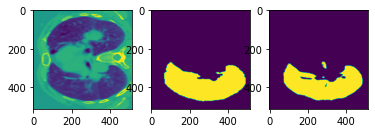

Epoch [3/100]   Batch 1208   Loss: 0.9999    lr: 0.0100000000
-------------------------
End of Epoch [3/100]   Dice Metric: 0.4084  IoU Metric: 0.3518  
  Precision Metric: 0.4020  Recall Metric: 0.2630


End of Epoch [3/100]   Dice Metric: 0.4084  IoU Metric: 0.3518
Epoch [4/100]   Batch 0   Loss: 0.9999    Max: 1.0000


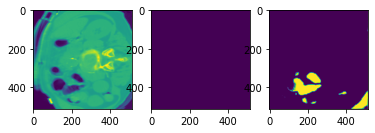

Epoch [4/100]   Batch 1000   Loss: 0.0299    Max: 1.0000


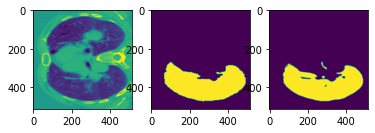

Epoch [4/100]   Batch 1208   Loss: 0.9999    lr: 0.0100000000
-------------------------
End of Epoch [4/100]   Dice Metric: 0.6304  IoU Metric: 0.5785  
  Precision Metric: 0.5726  Recall Metric: 0.5315


End of Epoch [4/100]   Dice Metric: 0.6304  IoU Metric: 0.5785
Epoch [5/100]   Batch 0   Loss: 0.9999    Max: 1.0000


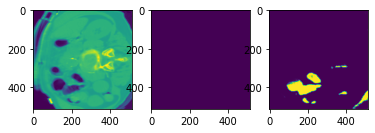

Epoch [5/100]   Batch 1000   Loss: 0.0309    Max: 1.0000


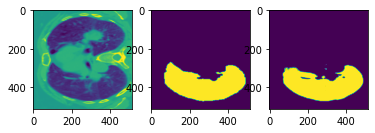

Epoch [5/100]   Batch 1208   Loss: 0.9999    lr: 0.0100000000
-------------------------
End of Epoch [5/100]   Dice Metric: 0.3177  IoU Metric: 0.3034  
  Precision Metric: 0.4095  Recall Metric: 0.0174


End of Epoch [5/100]   Dice Metric: 0.3177  IoU Metric: 0.3034
Epoch [6/100]   Batch 0   Loss: 0.9975    Max: 1.0000


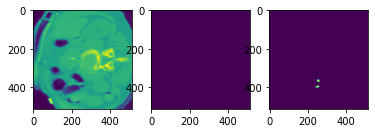

Epoch [6/100]   Batch 1000   Loss: 0.0303    Max: 1.0000


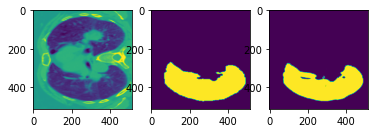

Epoch [6/100]   Batch 1208   Loss: 0.9999    lr: 0.0100000000
-------------------------
End of Epoch [6/100]   Dice Metric: 0.3516  IoU Metric: 0.2806  
  Precision Metric: 0.5392  Recall Metric: 0.1385


End of Epoch [6/100]   Dice Metric: 0.3516  IoU Metric: 0.2806
Epoch [7/100]   Batch 0   Loss: 0.9998    Max: 1.0000


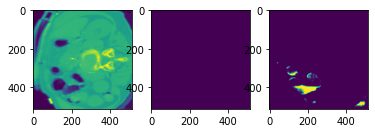

Epoch [7/100]   Batch 1000   Loss: 1.0000    Max: 0.0000


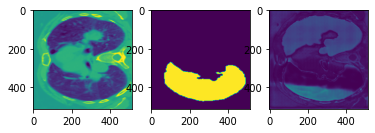

Epoch [7/100]   Batch 1208   Loss: 0.0019    lr: 0.0100000000
-------------------------
End of Epoch [7/100]   Dice Metric: 0.3594  IoU Metric: 0.3594  
  Precision Metric: 0.0000  Recall Metric: 0.0000


End of Epoch [7/100]   Dice Metric: 0.3594  IoU Metric: 0.3594
Epoch [8/100]   Batch 0   Loss: 0.0024    Max: 0.0000


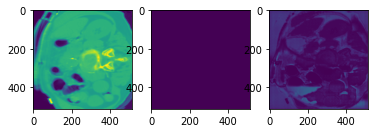

Epoch [8/100]   Batch 1000   Loss: 1.0000    Max: 0.0000


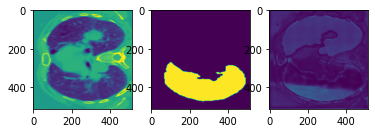

Epoch [8/100]   Batch 1208   Loss: 0.0012    lr: 0.0100000000
-------------------------
End of Epoch [8/100]   Dice Metric: 0.3594  IoU Metric: 0.3594  
  Precision Metric: 0.0000  Recall Metric: 0.0000


End of Epoch [8/100]   Dice Metric: 0.3594  IoU Metric: 0.3594
Epoch [9/100]   Batch 0   Loss: 0.0015    Max: 0.0000


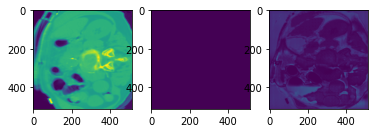

Epoch [9/100]   Batch 1000   Loss: 1.0000    Max: 0.0000


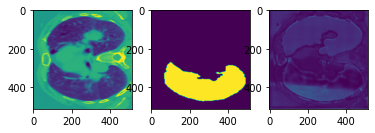

Epoch [9/100]   Batch 1208   Loss: 0.0009    lr: 0.0100000000
-------------------------
End of Epoch [9/100]   Dice Metric: 0.3594  IoU Metric: 0.3594  
  Precision Metric: 0.0000  Recall Metric: 0.0000


End of Epoch [9/100]   Dice Metric: 0.3594  IoU Metric: 0.3594
Epoch [10/100]   Batch 0   Loss: 0.0011    Max: 0.0000


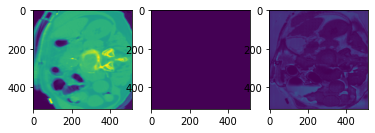

Epoch [10/100]   Batch 1000   Loss: 1.0000    Max: 0.0000


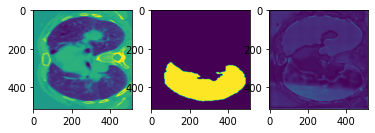

Epoch [10/100]   Batch 1208   Loss: 0.0007    lr: 0.0100000000
-------------------------
End of Epoch [10/100]   Dice Metric: 0.3594  IoU Metric: 0.3594  
  Precision Metric: 0.0000  Recall Metric: 0.0000


End of Epoch [10/100]   Dice Metric: 0.3594  IoU Metric: 0.3594
Epoch [11/100]   Batch 0   Loss: 0.0009    Max: 0.0000


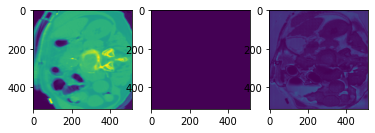

Epoch [11/100]   Batch 1000   Loss: 1.0000    Max: 0.0000


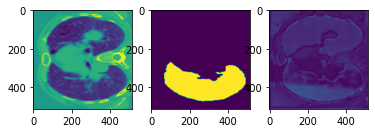

Epoch [11/100]   Batch 1208   Loss: 0.0006    lr: 0.0100000000
-------------------------
End of Epoch [11/100]   Dice Metric: 0.3594  IoU Metric: 0.3594  
  Precision Metric: 0.0000  Recall Metric: 0.0000


End of Epoch [11/100]   Dice Metric: 0.3594  IoU Metric: 0.3594
Epoch [12/100]   Batch 0   Loss: 0.0008    Max: 0.0000


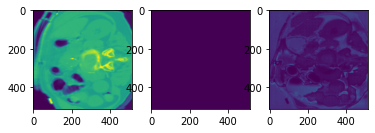

Epoch [12/100]   Batch 1000   Loss: 1.0000    Max: 0.0000


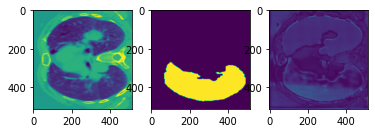

Epoch [12/100]   Batch 1208   Loss: 0.0006    lr: 0.0100000000
-------------------------
End of Epoch [12/100]   Dice Metric: 0.3594  IoU Metric: 0.3594  
  Precision Metric: 0.0000  Recall Metric: 0.0000


End of Epoch [12/100]   Dice Metric: 0.3594  IoU Metric: 0.3594
Epoch [13/100]   Batch 0   Loss: 0.0007    Max: 0.0000


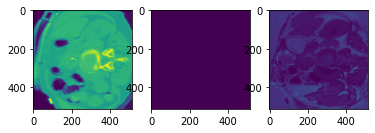

Epoch [13/100]   Batch 1000   Loss: 1.0000    Max: 0.0000


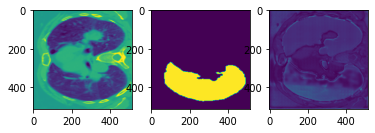

Epoch [13/100]   Batch 1208   Loss: 0.0005    lr: 0.0100000000
-------------------------
End of Epoch [13/100]   Dice Metric: 0.3594  IoU Metric: 0.3594  
  Precision Metric: 0.0000  Recall Metric: 0.0000


End of Epoch [13/100]   Dice Metric: 0.3594  IoU Metric: 0.3594
Epoch [14/100]   Batch 0   Loss: 0.0006    Max: 0.0000


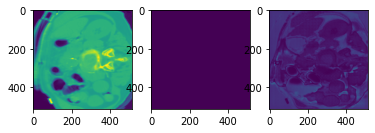

Epoch [14/100]   Batch 1000   Loss: 1.0000    Max: 0.0000


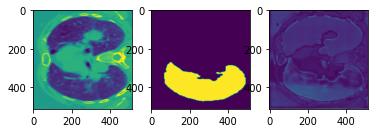

Epoch [14/100]   Batch 1208   Loss: 0.0005    lr: 0.0100000000
-------------------------
End of Epoch [14/100]   Dice Metric: 0.3594  IoU Metric: 0.3594  
  Precision Metric: 0.0000  Recall Metric: 0.0000


End of Epoch [14/100]   Dice Metric: 0.3594  IoU Metric: 0.3594
Epoch [15/100]   Batch 0   Loss: 0.0005    Max: 0.0000


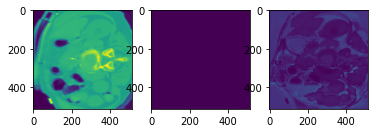

Epoch [15/100]   Batch 1000   Loss: 1.0000    Max: 0.0000


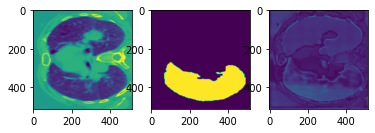

Epoch [15/100]   Batch 1208   Loss: 0.0004    lr: 0.0100000000
-------------------------
End of Epoch [15/100]   Dice Metric: 0.3594  IoU Metric: 0.3594  
  Precision Metric: 0.0000  Recall Metric: 0.0000


End of Epoch [15/100]   Dice Metric: 0.3594  IoU Metric: 0.3594
Epoch [16/100]   Batch 0   Loss: 0.0005    Max: 0.0000


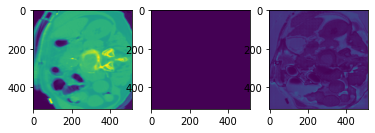

Epoch [16/100]   Batch 1000   Loss: 1.0000    Max: 0.0000


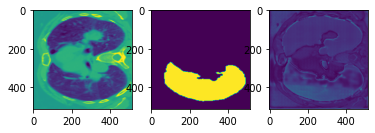

Epoch [16/100]   Batch 1208   Loss: 0.0004    lr: 0.0100000000
-------------------------
End of Epoch [16/100]   Dice Metric: 0.3594  IoU Metric: 0.3594  
  Precision Metric: 0.0000  Recall Metric: 0.0000


End of Epoch [16/100]   Dice Metric: 0.3594  IoU Metric: 0.3594
Epoch [17/100]   Batch 0   Loss: 0.0004    Max: 0.0000


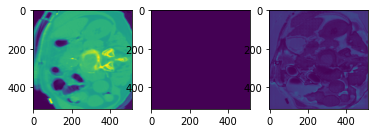

Epoch [17/100]   Batch 1000   Loss: 1.0000    Max: 0.0000


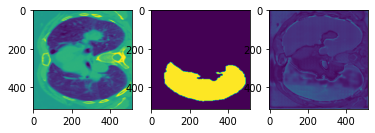

Epoch [17/100]   Batch 1208   Loss: 0.0004    lr: 0.0100000000
-------------------------
End of Epoch [17/100]   Dice Metric: 0.3594  IoU Metric: 0.3594  
  Precision Metric: 0.0000  Recall Metric: 0.0000


End of Epoch [17/100]   Dice Metric: 0.3594  IoU Metric: 0.3594
Epoch [18/100]   Batch 0   Loss: 0.0004    Max: 0.0000


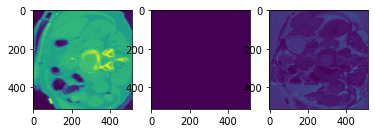

Epoch [18/100]   Batch 1000   Loss: 1.0000    Max: 0.0000


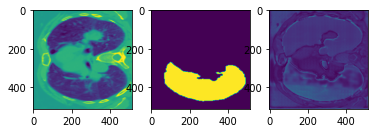

Epoch [18/100]   Batch 1208   Loss: 0.0003    lr: 0.0100000000
-------------------------
End of Epoch [18/100]   Dice Metric: 0.3594  IoU Metric: 0.3594  
  Precision Metric: 0.0000  Recall Metric: 0.0000


End of Epoch [18/100]   Dice Metric: 0.3594  IoU Metric: 0.3594
Epoch [19/100]   Batch 0   Loss: 0.0004    Max: 0.0000


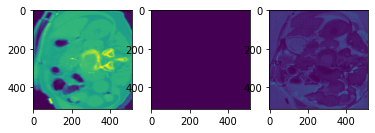

Epoch [19/100]   Batch 1000   Loss: 1.0000    Max: 0.0000


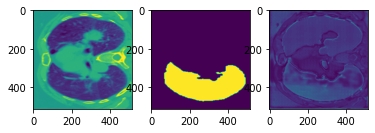

Epoch [19/100]   Batch 1208   Loss: 0.0003    lr: 0.0100000000
-------------------------
End of Epoch [19/100]   Dice Metric: 0.3594  IoU Metric: 0.3594  
  Precision Metric: 0.0000  Recall Metric: 0.0000


End of Epoch [19/100]   Dice Metric: 0.3594  IoU Metric: 0.3594
Epoch [20/100]   Batch 0   Loss: 0.0004    Max: 0.0000


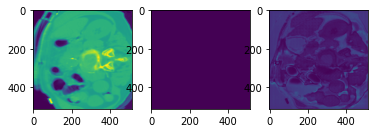

Epoch [20/100]   Batch 1000   Loss: 1.0000    Max: 0.0000


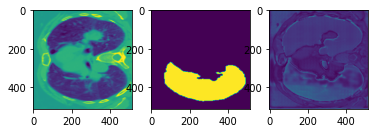

Epoch [20/100]   Batch 1208   Loss: 0.0003    lr: 0.0100000000
-------------------------
End of Epoch [20/100]   Dice Metric: 0.3594  IoU Metric: 0.3594  
  Precision Metric: 0.0000  Recall Metric: 0.0000


End of Epoch [20/100]   Dice Metric: 0.3594  IoU Metric: 0.3594
Epoch [21/100]   Batch 0   Loss: 0.0003    Max: 0.0000


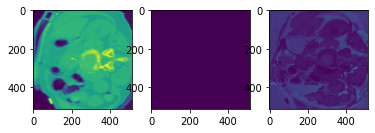

Epoch [21/100]   Batch 1000   Loss: 1.0000    Max: 0.0000


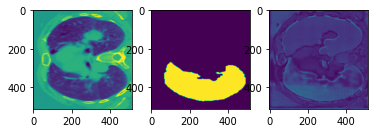

Epoch [21/100]   Batch 1208   Loss: 0.0003    lr: 0.0100000000
-------------------------
End of Epoch [21/100]   Dice Metric: 0.3594  IoU Metric: 0.3594  
  Precision Metric: 0.0000  Recall Metric: 0.0000


End of Epoch [21/100]   Dice Metric: 0.3594  IoU Metric: 0.3594
Epoch [22/100]   Batch 0   Loss: 0.0003    Max: 0.0000


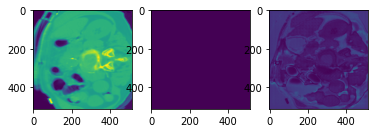

Epoch [22/100]   Batch 1000   Loss: 1.0000    Max: 0.0000


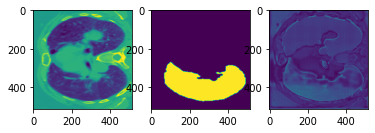

Epoch [22/100]   Batch 1208   Loss: 0.0003    lr: 0.0100000000
-------------------------
End of Epoch [22/100]   Dice Metric: 0.3594  IoU Metric: 0.3594  
  Precision Metric: 0.0000  Recall Metric: 0.0000


End of Epoch [22/100]   Dice Metric: 0.3594  IoU Metric: 0.3594
Epoch [23/100]   Batch 0   Loss: 0.0003    Max: 0.0000


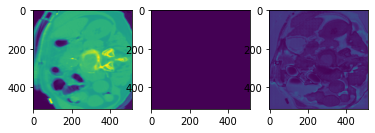

Epoch [23/100]   Batch 1000   Loss: 1.0000    Max: 0.0000


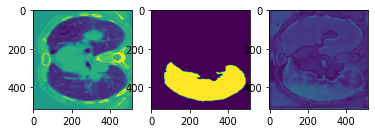

Epoch [23/100]   Batch 1208   Loss: 0.0003    lr: 0.0100000000
-------------------------
End of Epoch [23/100]   Dice Metric: 0.3594  IoU Metric: 0.3594  
  Precision Metric: 0.0000  Recall Metric: 0.0000


End of Epoch [23/100]   Dice Metric: 0.3594  IoU Metric: 0.3594
Epoch [24/100]   Batch 0   Loss: 0.0003    Max: 0.0000


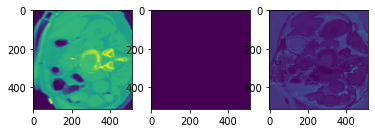

Epoch [24/100]   Batch 1000   Loss: 1.0000    Max: 0.0000


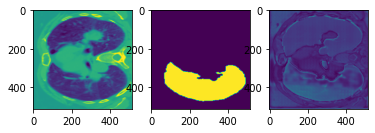

Epoch [24/100]   Batch 1208   Loss: 0.0002    lr: 0.0100000000
-------------------------
End of Epoch [24/100]   Dice Metric: 0.3594  IoU Metric: 0.3594  
  Precision Metric: 0.0000  Recall Metric: 0.0000


End of Epoch [24/100]   Dice Metric: 0.3594  IoU Metric: 0.3594
Epoch [25/100]   Batch 0   Loss: 0.0003    Max: 0.0000


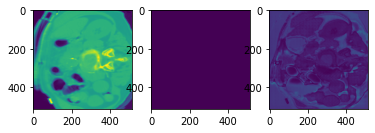

Epoch [25/100]   Batch 1000   Loss: 1.0000    Max: 0.0000


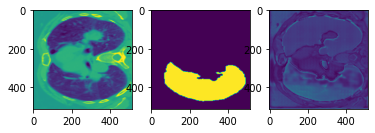

Epoch [25/100]   Batch 1208   Loss: 0.0002    lr: 0.0100000000
-------------------------
End of Epoch [25/100]   Dice Metric: 0.3594  IoU Metric: 0.3594  
  Precision Metric: 0.0000  Recall Metric: 0.0000


End of Epoch [25/100]   Dice Metric: 0.3594  IoU Metric: 0.3594
Epoch [26/100]   Batch 0   Loss: 0.0003    Max: 0.0000


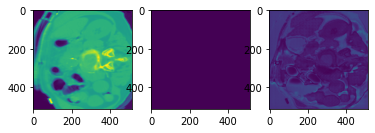

Epoch [26/100]   Batch 1000   Loss: 1.0000    Max: 0.0000


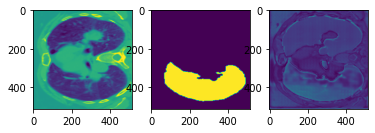

Epoch [26/100]   Batch 1208   Loss: 0.0002    lr: 0.0100000000
-------------------------
End of Epoch [26/100]   Dice Metric: 0.3594  IoU Metric: 0.3594  
  Precision Metric: 0.0000  Recall Metric: 0.0000


End of Epoch [26/100]   Dice Metric: 0.3594  IoU Metric: 0.3594
Epoch [27/100]   Batch 0   Loss: 0.0002    Max: 0.0000


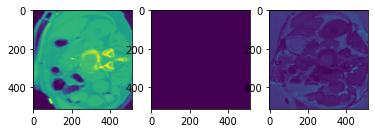

Epoch [27/100]   Batch 1000   Loss: 1.0000    Max: 0.0000


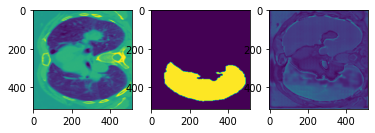

Epoch [27/100]   Batch 1208   Loss: 0.0002    lr: 0.0100000000
-------------------------
End of Epoch [27/100]   Dice Metric: 0.3594  IoU Metric: 0.3594  
  Precision Metric: 0.0000  Recall Metric: 0.0000


End of Epoch [27/100]   Dice Metric: 0.3594  IoU Metric: 0.3594
Epoch [28/100]   Batch 0   Loss: 0.0002    Max: 0.0000


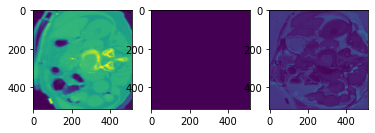

Epoch [28/100]   Batch 1000   Loss: 1.0000    Max: 0.0000


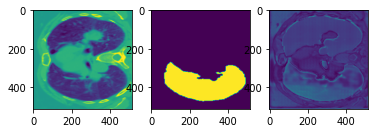

Epoch [28/100]   Batch 1208   Loss: 0.0002    lr: 0.0100000000
-------------------------
End of Epoch [28/100]   Dice Metric: 0.3594  IoU Metric: 0.3594  
  Precision Metric: 0.0000  Recall Metric: 0.0000


End of Epoch [28/100]   Dice Metric: 0.3594  IoU Metric: 0.3594
Epoch [29/100]   Batch 0   Loss: 0.0002    Max: 0.0000


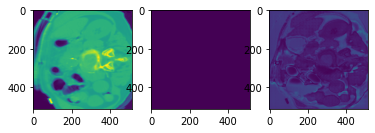

In [ ]:
fit(model=model, img_size=img_size, seg_organ=seg_organ, window_size=window_size,
    loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler,
    epochs=epochs, train_df=train_df, test_df=test_df, 
    validate=True, print_every=1000)

In [ ]:
eval(model=model,test_df=test_df,img_size=img_size,seg_organ=seg_organ,window_size=window_size)

In [ ]:
torch.save(model.state_dict(), 'adv_sma_wag_lung_l_100epochs')